# Stock Market Portfolio Optimization with Python

Install necessary Python libraries and collect stock market data using yfinacne API.

In [ ]:
pip install yfinance

In [ ]:
import pandas as pd
import yfinance as yf

In [ ]:
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date       Ticker    Adj Close        Close         High  \
0         2023-07-31  HDFCBANK.NS  1628.955811  1651.199951  1656.800049   
1         2023-07-31      INFY.NS  1330.875854  1355.699951  1357.500000   
2         2023-07-31  RELIANCE.NS  2540.276611  2549.250000  2553.899902   
3         2023-07-31       TCS.NS  3364.554199  3421.449951  3426.649902   
4         2023-08-01  HDFCBANK.NS  1639.857056  1662.250000  1667.449951   

Attribute          Low         Open      Volume  
0          1638.699951  1650.050049  17282503.0  
1          1333.250000  1348.750000   7902180.0  
2          2517.949951  2527.850098   4275587.0  
3          3360.899902  3364.399902   2743678.0  
4          1650.000000  1654.449951  17697094.0  


Now, lets have a look at the stock market performance of these companies. (Reliance, TCS, INFY, HDFC Bank)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

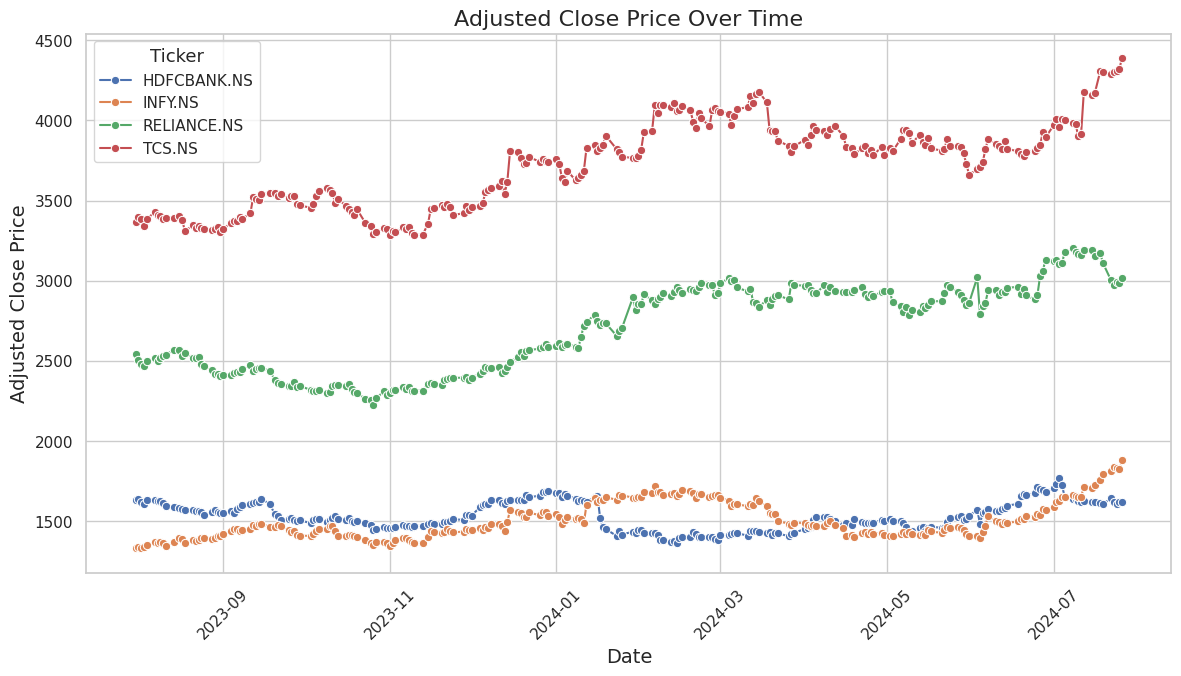

In [ ]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date',inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14,7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data,x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation = 45)

plt.show()


The graph displays the adjusted close prices of four stocks (HDFCBANK.NS, INFY.NS, RELIANCE.NS, TCS.NS) over time from **July 2023 to July 2024**. It highlights that TCS has the highest adjusted close prices, followed by RELIANCE, INFY (Infosys), and HDFCBANK. The prices for RELIANCE and TCS show noticeable upward trends, which indicates strong performance, while HDFCBANK and INFY exhibit more stability with relatively lower price fluctuations.

Now, let's compute the 50-dat and 200-day moving averages and plot these along with the Adjusted Close Price for each stock:

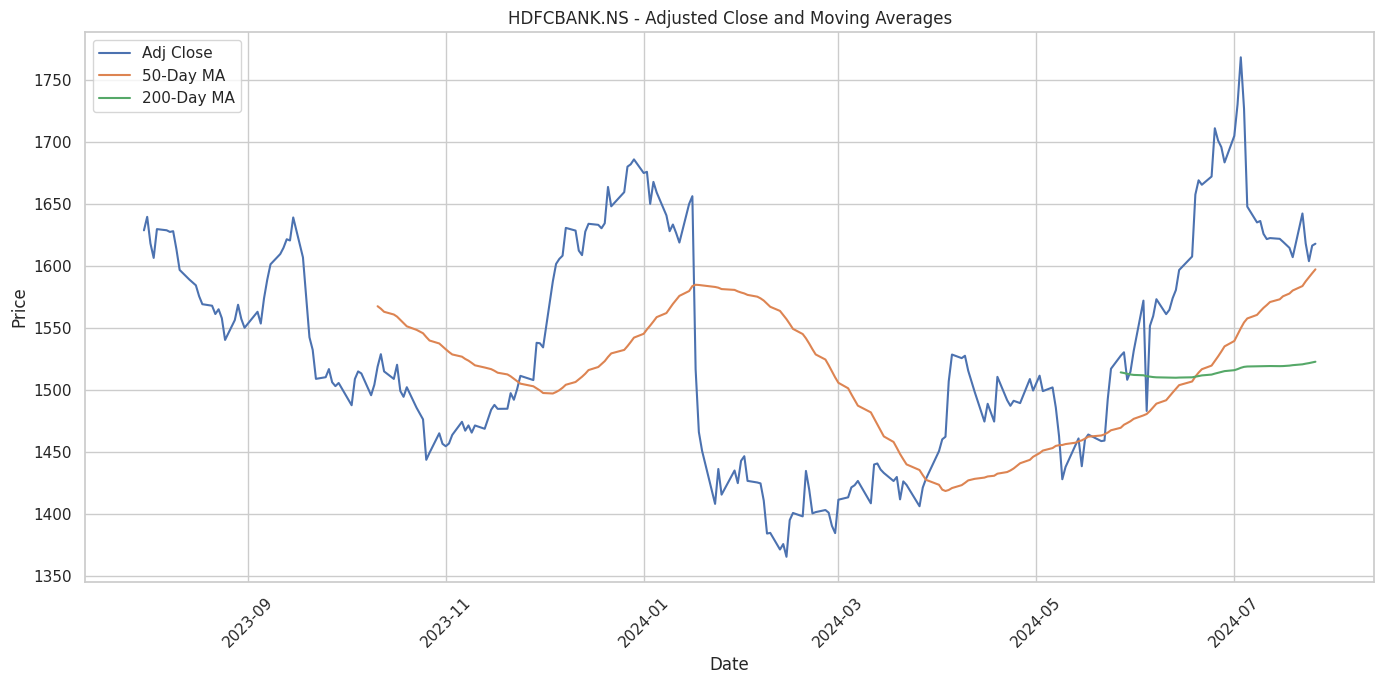

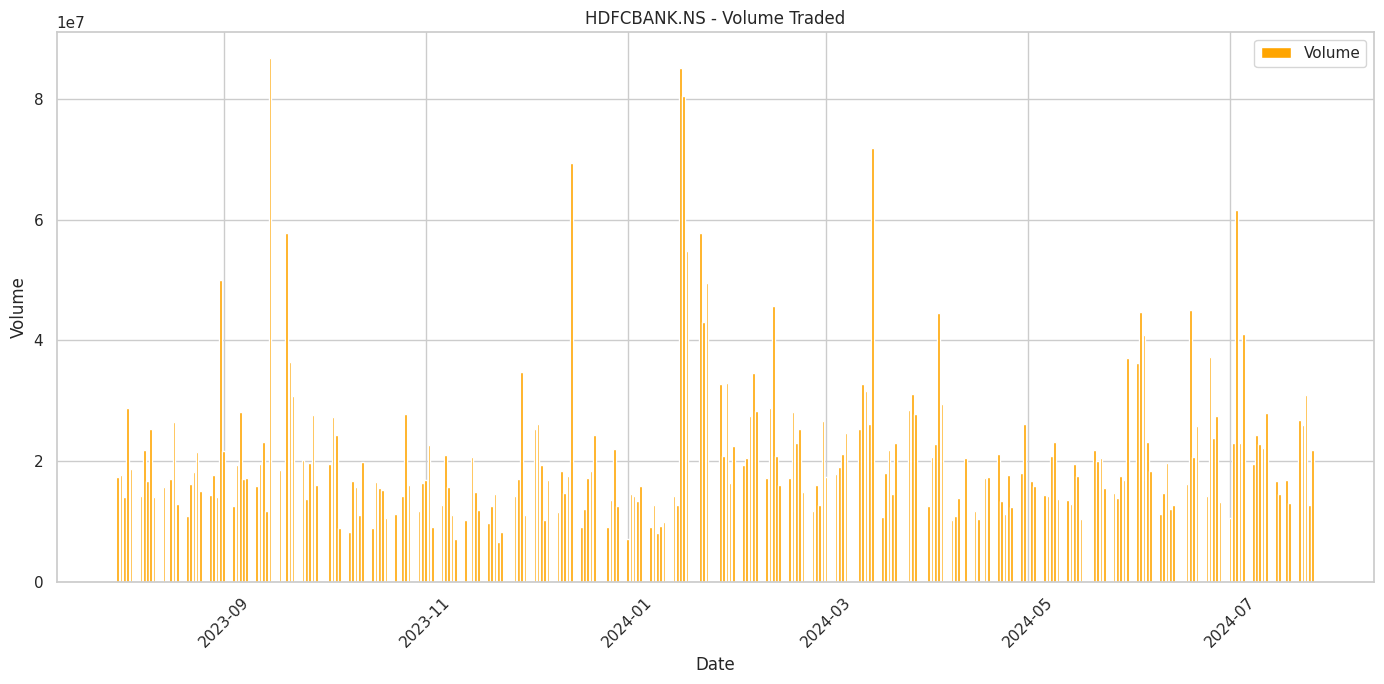

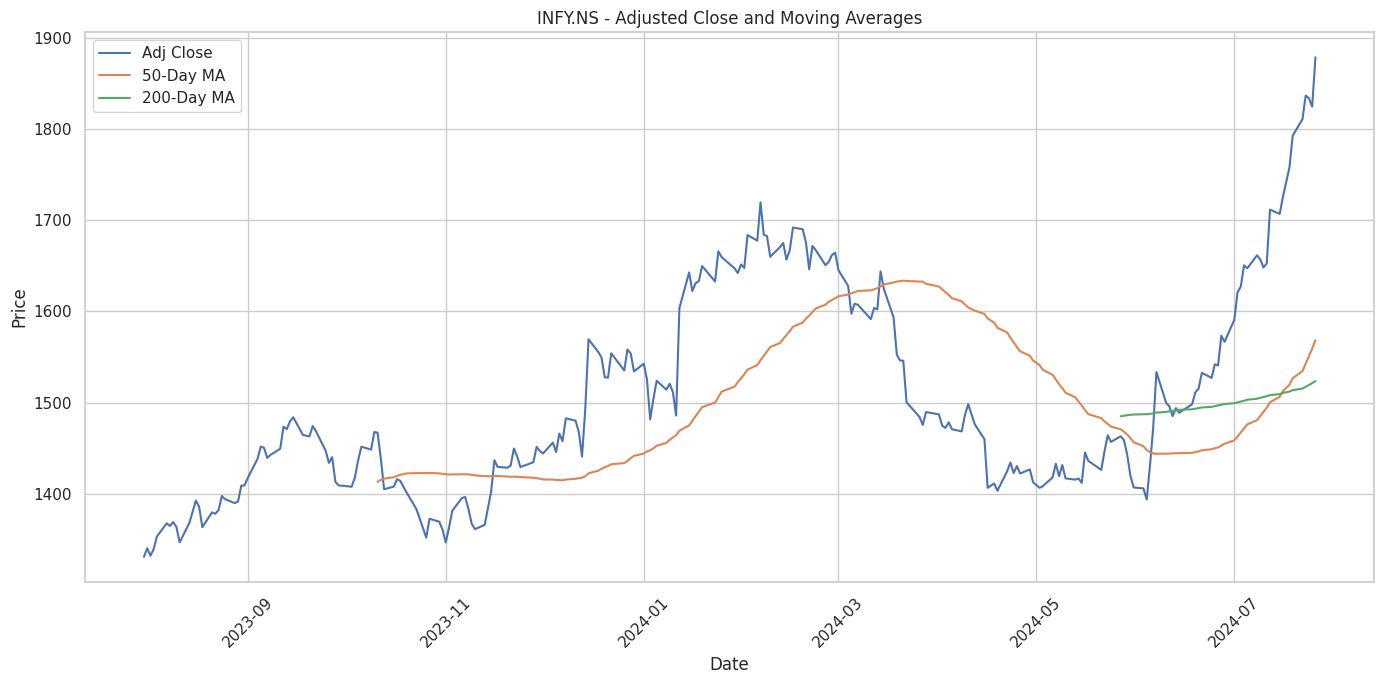

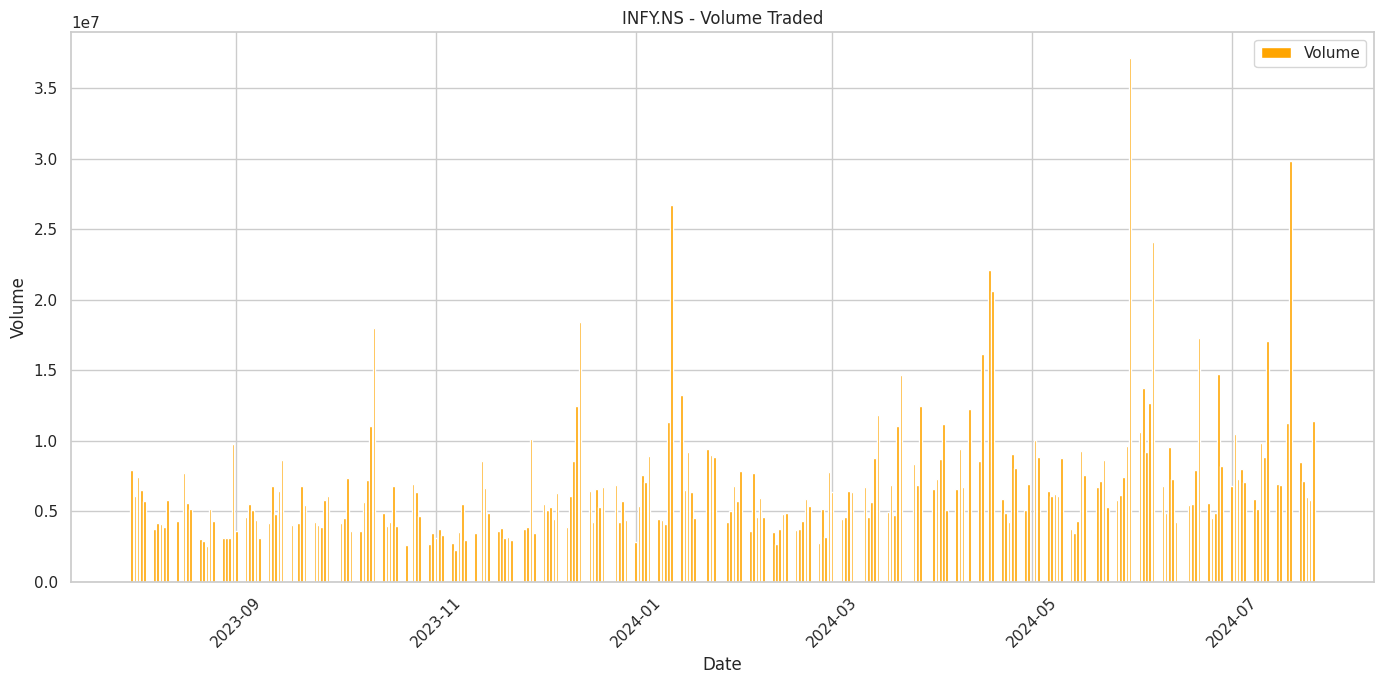

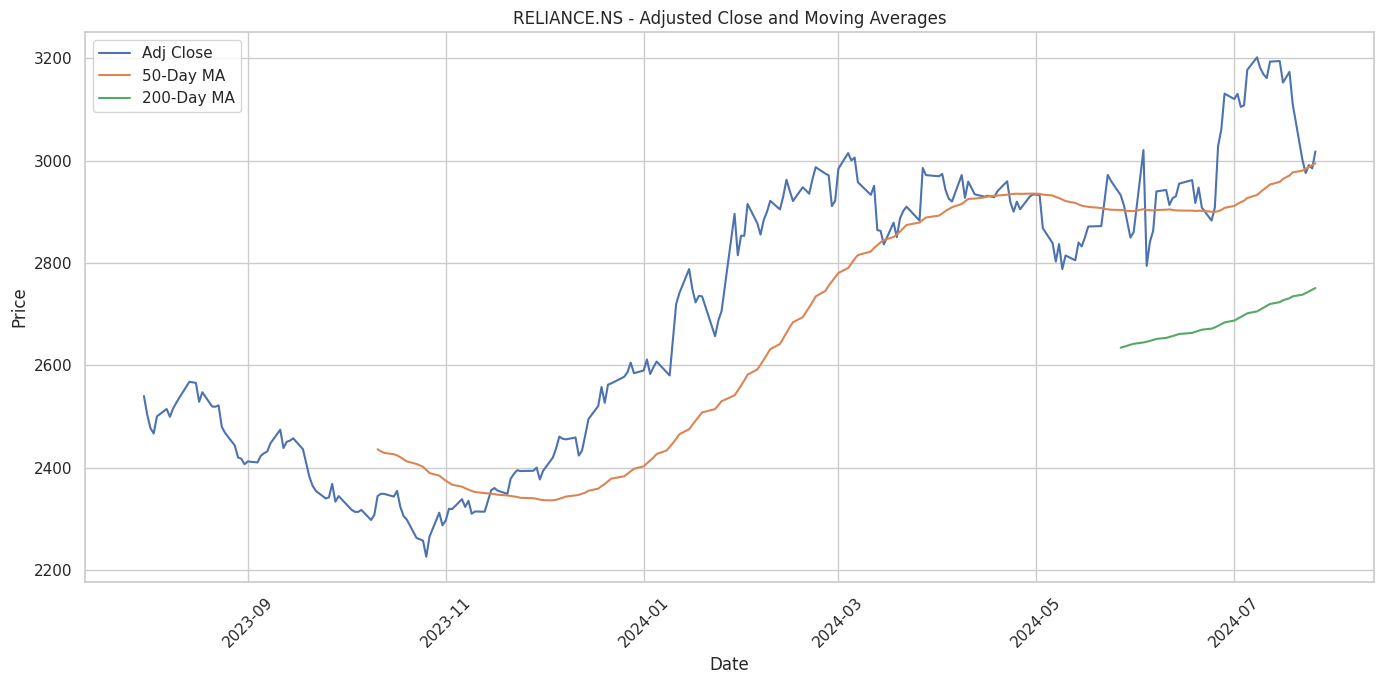

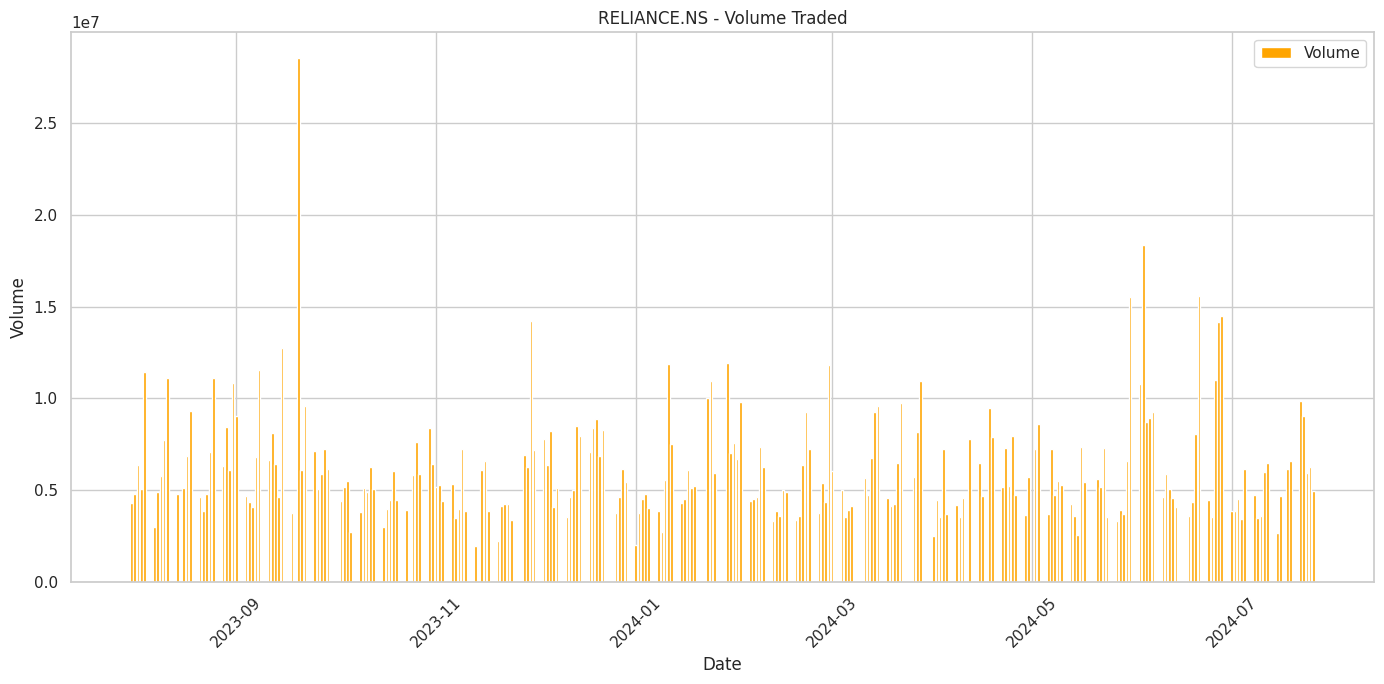

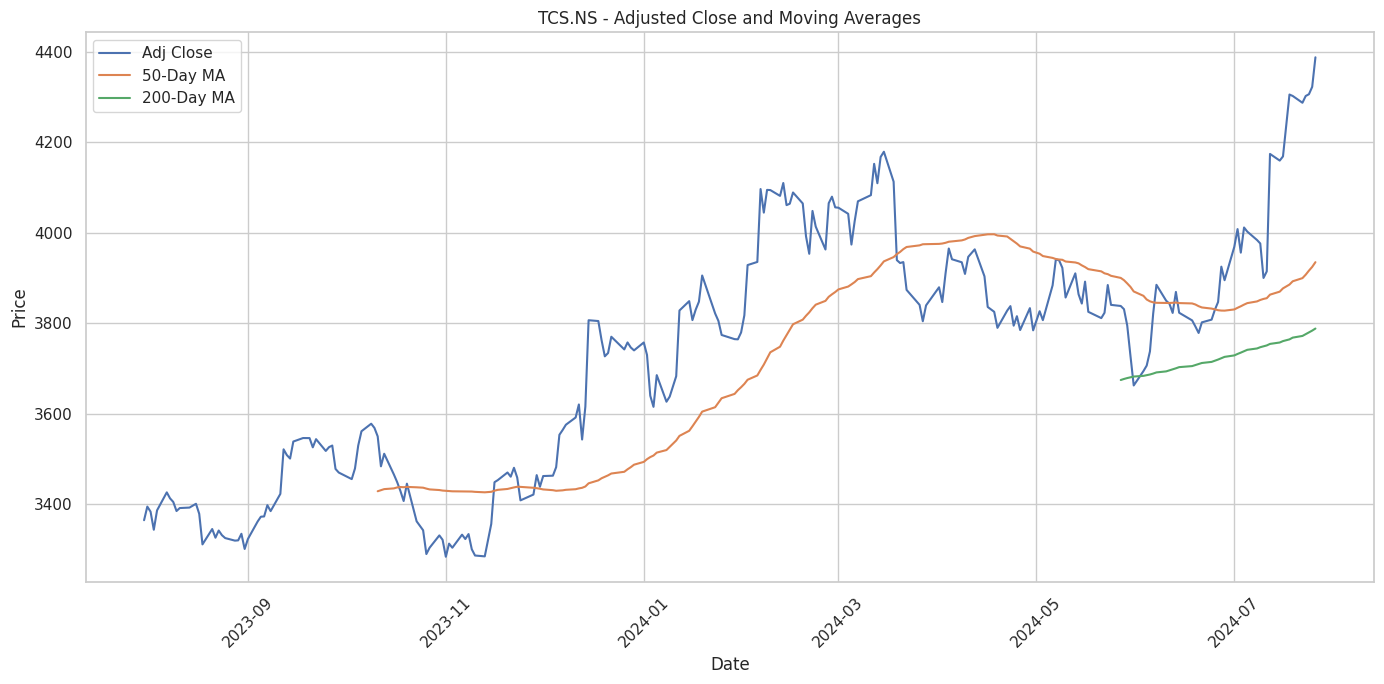

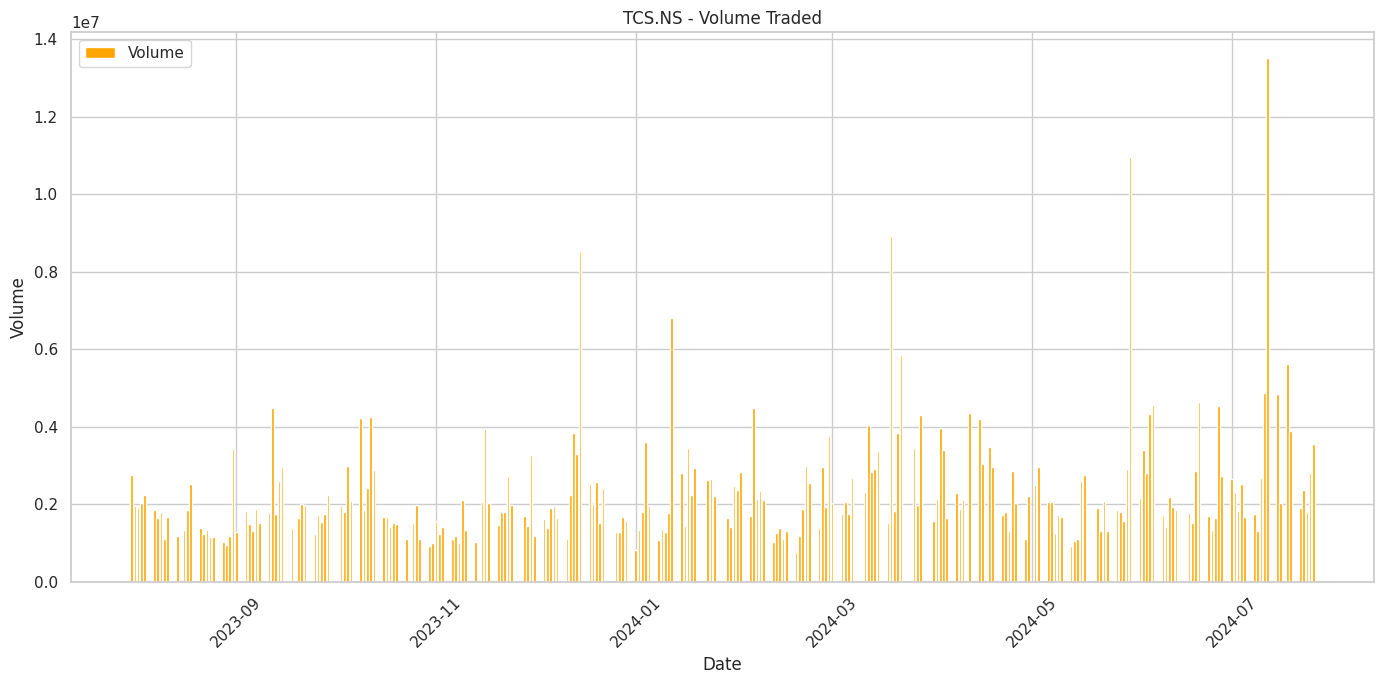

In [ ]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

For HDFCBANK and INFY, the prices initially decline but later show signs of recovery, as indicated by the moving averages. RELIANCE and TCS display a more consistent upward trend in their adjusted close prices. The volume traded graphs highlight significant trading activity at various points, with spikes indicating high trading volumes, particularly noticeable in HDFCBANK and RELIANCE around early 2024. These insights are crucial for understanding price movements and trading behaviours, which assist in making informed investment decisions.

Now, let’s have a look at the distribution of daily returns of these stocks:

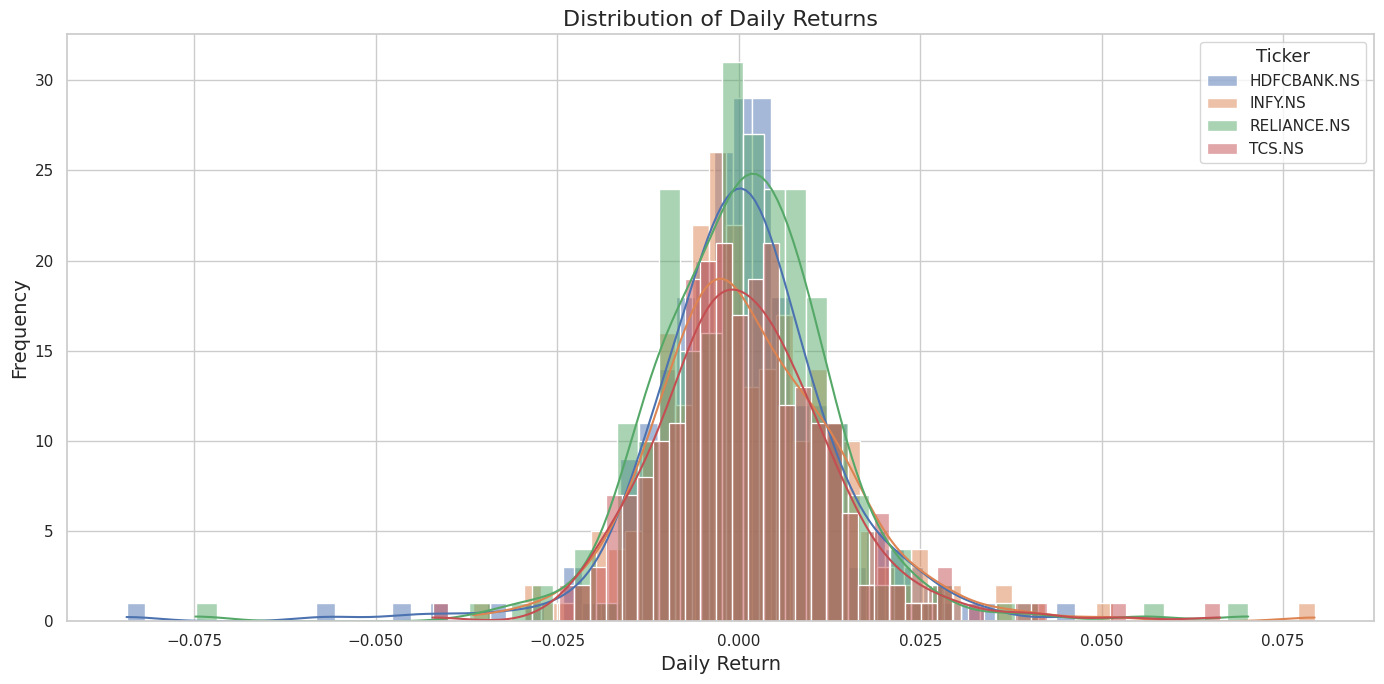

In [ ]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

The distributions are approximately normal, centred around zero, which indicates that most daily returns are close to the average return. However, there are tails on both sides, which reflect occasional significant gains or losses. INFY and RELIANCE appear to have slightly wider distributions, which suggests higher volatility compared to HDFCBANK and TCS.

Now, let’s see if there’s any correlation between all these stocks:

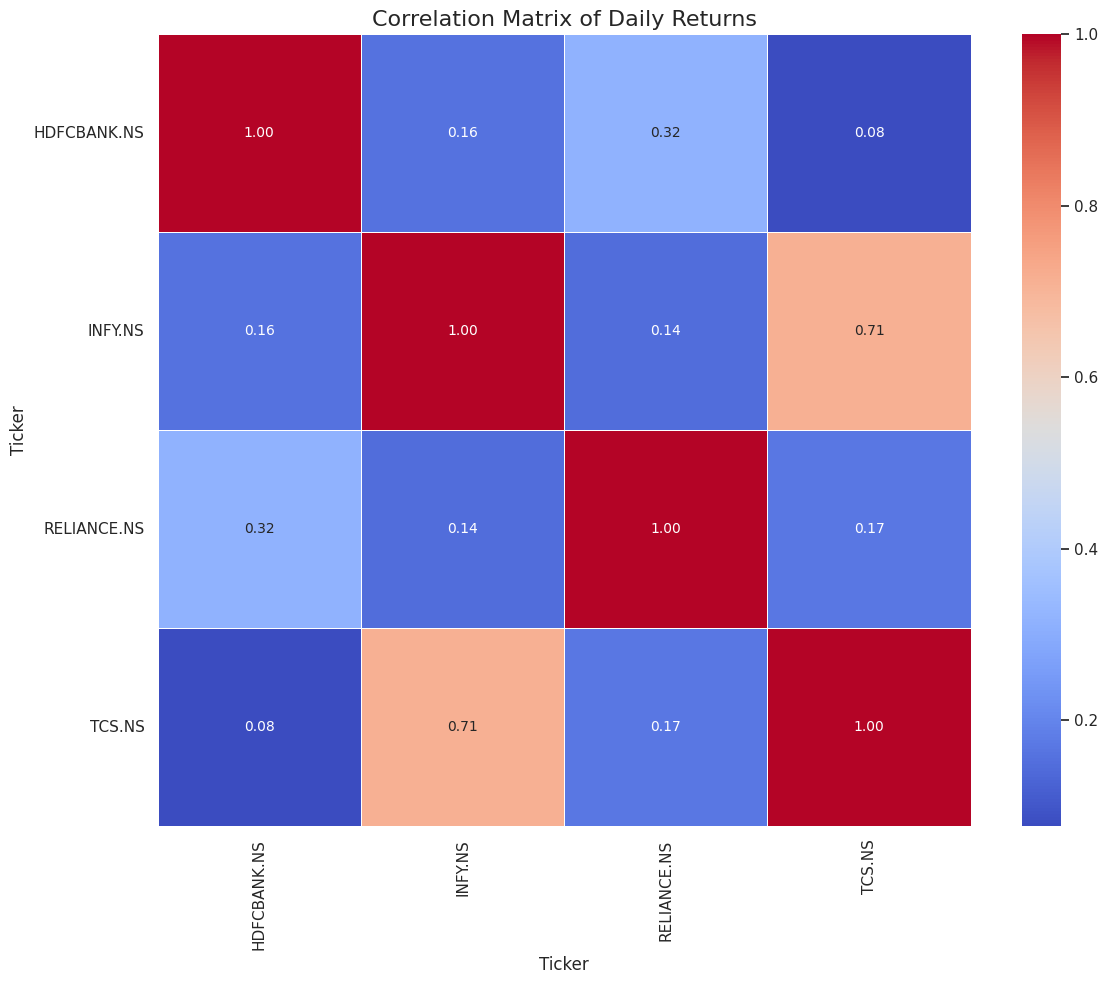

In [ ]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

INFY and TCS have a high positive correlation (0.71), which indicates that they tend to move in the same direction. HDFCBANK has a moderate positive correlation with RELIANCE (0.37) and a low correlation with INFY (0.17) and TCS (0.10). RELIANCE shows a low correlation with INFY (0.19) and TCS (0.13). These varying correlations suggest potential diversification benefits; combining stocks with lower correlations can reduce overall portfolio risk.

# Portfolio Optimization

Now, using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return. We will:

1. Calculate the expected returns and volatility for each stock.
2. Generate a series of random portfolios to identify the efficient frontier.
3. Optimize the portfolio to maximize the Sharpe ratio, which is a measure of risk-adjusted return.

Let’s calculate the expected returns and volatility for each stock:

In [ ]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.015834,0.212680
INFY.NS,0.383492,0.214435
RELIANCE.NS,0.202437,0.211128
TCS.NS,0.297850,0.201472


RELIANCE has the highest expected return (29.73%) and moderate volatility (21.47%), which indicates a potentially high-reward investment with relatively higher risk. INFY and TCS also have high expected returns (21.38% and 22.09% respectively) with moderate volatility (23.23% and 19.69%). HDFCBANK has the lowest expected return (1.37%) and moderate volatility (20.69%), which makes it the least attractive in terms of risk-adjusted returns.

Next, we will:

1. Generate a large number of random portfolio weights.
2. Calculate the expected return and volatility for each portfolio.
3. Plot these portfolios to visualize the efficient frontier.

Let’s generate the random portfolios and plot the efficient frontier:

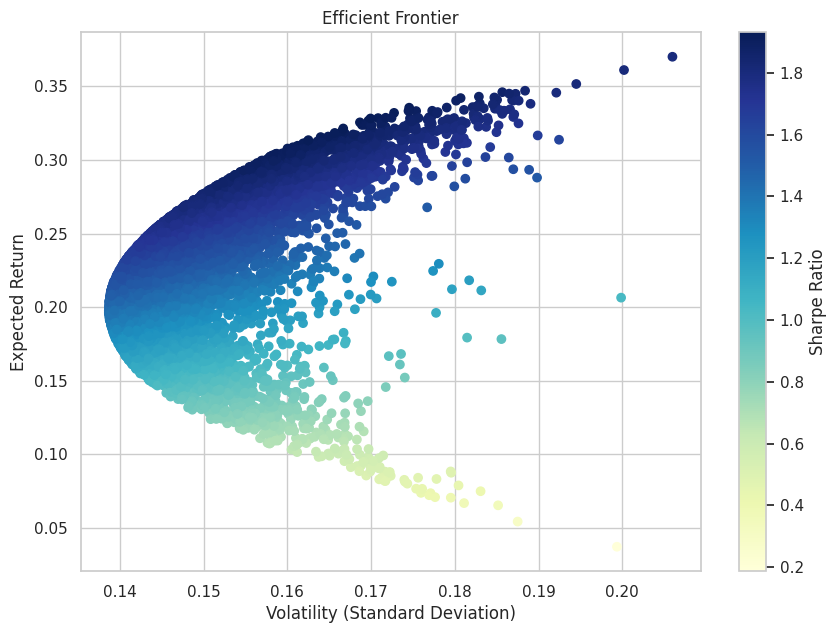

In [ ]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

Each dot represents a portfolio, with the colour indicating the Sharpe ratio, a measure of risk-adjusted return. Portfolios on the leftmost edge of the frontier (closer to the y-axis) offer the highest expected returns for a given level of volatility, which represent optimal portfolios. The gradient shows that portfolios with higher Sharpe ratios (darker blue) provide better risk-adjusted returns.

Here’s how to identify the portfolio with the maximum Sharpe ratio:

In [ ]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.32815439947205644, 0.16992861980914403, 1.9311308468262984)

The portfolio with the maximum Sharpe ratio has the following characteristics:

*  Expected Return: ~26.08%
*  Volatility: ~15.54%
*   Sharpe Ratio: ~1.68

Next, let’s identify the weights of the stocks in the portfolio that yield the maximum Sharpe ratio:



In [ ]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.331348
1,INFY.NS,0.230410
2,RELIANCE.NS,0.341841
3,TCS.NS,0.096401


The output shows a diversified portfolio with the following allocations:

1. HDFCBANK (30.85%)
2. INFY (10.59%)
3. RELIANCE (18.02%)
4. TCS (40.53%)

TCS has the highest allocation, which indicates its significant contribution to the portfolio’s performance, while INFY has the smallest allocation. This balanced allocation aims to maximize returns while minimizing risk by leveraging individual stock performances and their correlations.

# Summary

So, this is how stock market portfolio optimization works. Stock market portfolio optimization involves analyzing price trends, calculating expected returns and volatilities, and determining the correlations between different stocks to achieve diversification.